In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader

from src.util import *
import os

### Variables

In [2]:
# Folders containing the clean and dirty images
path_clean: str = "../dataset/pairs/clean"
path_dirty: str = "../dataset/pairs/dirty"
assert os.path.exists(path_clean)
assert os.path.exists(path_dirty)

# Index to map the clean images to the dirty images
index_file: str = "../dataset/pairs/clean_dirty_index.csv"
assert os.path.isfile(index_file)
assert index_file[-3:] == "csv"

# save folder
save_path = "../dl/images/baseline_mock/"

# Mocking Baselines

## Loading Test Data

In [3]:
df_clean_dirty = pd.read_csv(index_file).set_index("file_clean").sort_index()
df_clean = pd.Series(df_clean_dirty.index.unique())

limits = [int(limit * len(df_clean)) for limit in (0.9, 0.05, 0.05)]

train_dataset = df_clean[:limits[0]]
test_dataset = df_clean[limits[0]:limits[0] + limits[1]]
valid_dataset = df_clean[limits[0] + limits[1]:]

train_dataset = pd.DataFrame(train_dataset) \
    .merge(df_clean_dirty, left_on="file_clean", right_index=True).values.tolist()

test_dataset = pd.DataFrame(test_dataset) \
    .merge(df_clean_dirty, left_on="file_clean", right_index=True).values.tolist()

valid_dataset = pd.DataFrame(valid_dataset) \
    .merge(df_clean_dirty, left_on="file_clean", right_index=True).values.tolist()

print(f"New Sizes: train {len(train_dataset)} images, test {len(test_dataset)} images, validation {len(valid_dataset)} images")

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

New Sizes: train 165605 images, test 9200 images, validation 9205 images


In [4]:
# Defining transformer and loss function
criterion = nn.MSELoss()

## Baseline Returning white page

In [6]:
test_losses_white_image = []

with torch.no_grad():
    for i, (filenames_clean, filenames_dirty) in enumerate(test_loader):
        print("\rTest ", round(i / len(test_loader), 4), end="")
        
        images_clean = [preprocess_file(path_clean, ip, (416, 308)) for ip in filenames_clean]
        images_clean = torch.stack([flatten_tensor_list(t) for t, _ in images_clean]).squeeze(0)
        
        prediction_mock = torch.ones(images_clean.shape)
        
        if torch.cuda.is_available():
            prediction_mock, images_clean = prediction_mock.cuda(), images_clean.cuda()

        loss = criterion(prediction_mock, images_clean)
        test_losses_white_image.append(loss.item())

print(f"\nMean MSE Loss: {sum(test_losses_white_image) / len(test_loader)}")

Test  0.9999
Mean MSE Loss: 0.13809885613053388


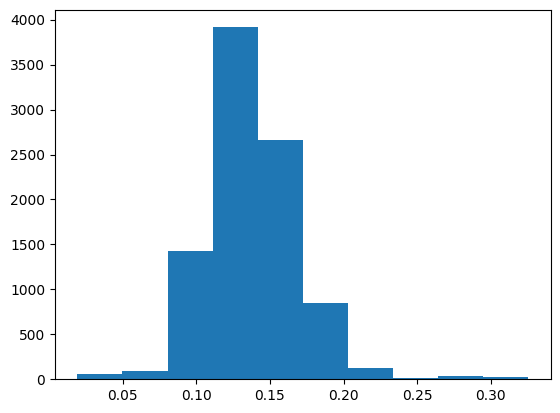

In [7]:
plt.hist(test_losses_white_image)
plt.savefig(f"{save_path}_white_image_test_losses.png")
plt.show()

## Baseline Returning Input Image

In [9]:
test_losses_input_image = []

with torch.no_grad():
    for i, (filenames_clean, filenames_dirty) in enumerate(test_loader):
        print("\rTest ", round(i / len(test_loader), 4), end="")

        images_clean = [preprocess_file(path_clean, ip, (416, 308)) for ip in filenames_clean]
        images_clean = torch.stack([flatten_tensor_list(t) for t, _ in images_clean]).squeeze(0)
        
        prediction_mock = [preprocess_file(path_dirty, ib, (416, 308)) for ib in filenames_dirty]
        prediction_mock = torch.stack([flatten_tensor_list(t) for t, _ in prediction_mock]).squeeze(0)

        if torch.cuda.is_available():
            prediction_mock, images_clean = prediction_mock.cuda(), images_clean.cuda()

        loss = criterion(prediction_mock, images_clean)
        test_losses_input_image.append(loss.item())

print(f"\nMean MSE Loss: {sum(test_losses_input_image) / len(test_loader)}")

Test  0.9999
Mean MSE Loss: 0.4885219611546658


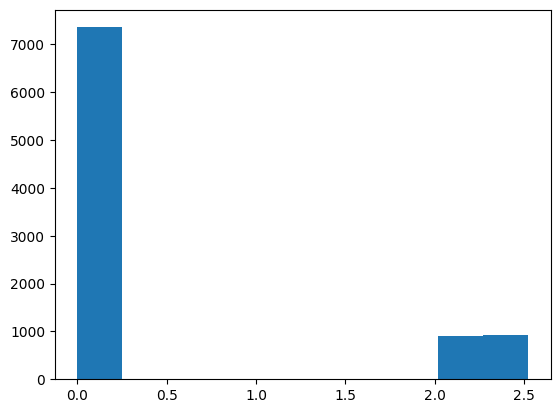

In [10]:
plt.hist(test_losses_input_image)
plt.savefig(f"{save_path}_input_image_test_losses.png")
plt.show()

In [11]:
test_losses_random = []

with torch.no_grad():
    for i, (filenames_clean, filenames_dirty) in enumerate(test_loader):
        print("\rTest ", round(i / len(test_loader), 4), end="")

        images_clean = [preprocess_file(path_clean, ip, (416, 308)) for ip in filenames_clean]
        images_clean = torch.stack([flatten_tensor_list(t) for t, _ in images_clean]).squeeze(0)
        
        prediction_mock = torch.rand(images_clean.shape)

        if torch.cuda.is_available():
            prediction_mock, images_clean = prediction_mock.cuda(), images_clean.cuda()

        loss = criterion(prediction_mock, images_clean)
        test_losses_random.append(loss.item())

print(f"\nMean MSE Loss: {sum(test_losses_random) / len(test_loader)}")

Test  0.9999
Mean MSE Loss: 0.39225561916828156


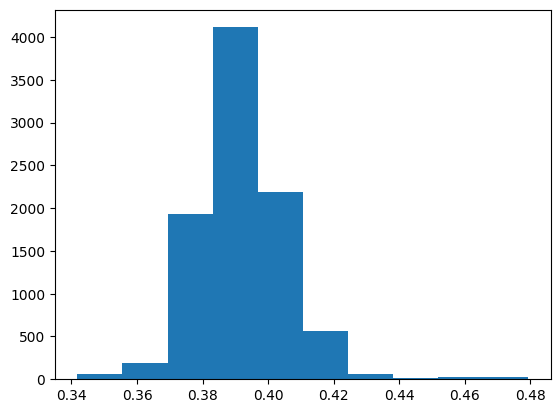

In [12]:
plt.hist(test_losses_random)
plt.savefig(f"{save_path}_input_image_test_losses.png")
plt.show()